# 🏗️ Earthquake Damage in Nepal
This notebook explores earthquake damage data from Nepal to identify key building features linked to severe damage.

**Steps:**
1. Load and explore the data  
2. Join datasets with SQL  
3. Clean and engineer features  
4. Train and evaluate machine learning models  
5. Visualize results


In [9]:
# Install dependencies if needed
# %pip install ipython-sql category_encoders scikit-learn matplotlib seaborn

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [10]:
# Use relative paths so this notebook runs anywhere
id_map_path = "../data/raw/id_map.csv"
structure_path = "../data/raw/building_structure.csv"
damage_path = "../data/raw/building_damage.csv"

id_map = pd.read_csv(id_map_path)
structure = pd.read_csv(structure_path)
damage = pd.read_csv(damage_path)

print("✅ Data successfully loaded!")
print(f"id_map: {id_map.shape}, structure: {structure.shape}, damage: {damage.shape}")


✅ Data successfully loaded!
id_map: (2000, 2), structure: (2000, 9), damage: (2000, 2)


In [11]:
conn = sqlite3.connect(":memory:")
id_map.to_sql("id_map", conn, index=False, if_exists="replace")
structure.to_sql("building_structure", conn, index=False, if_exists="replace")
damage.to_sql("building_damage", conn, index=False, if_exists="replace")

query = """
SELECT i.building_id, s.*, d.damage_grade
FROM id_map i
JOIN building_structure s ON i.building_id = s.building_id
JOIN building_damage d ON i.building_id = d.building_id
WHERE district_id = 3
"""
df = pd.read_sql(query, conn)
conn.close()
print("✅ Combined dataset shape:", df.shape)
df.head()


✅ Combined dataset shape: (693, 11)


,building_id,building_id,roof_type,plinth_area_sq_ft,foundation_type,ground_floor_type,position,plan_configuration,count_floors_pre_eq,count_floors_post_eq,damage_grade
0,3,3,Concrete,1039,RC,Brick,Not Attached,T-Shaped,2,4,Grade 4
1,4,4,Concrete,718,Brick,RC,Attached,Rectangular,1,3,Grade 1
2,9,9,Tile,1214,RC,Brick,Not Attached,Rectangular,2,3,Grade 3
3,10,10,Tile,794,Brick,RC,Attached,Square,1,1,Grade 3
4,18,18,Metal,1349,RC,Brick,Not Attached,T-Shaped,4,4,Grade 4


In [12]:
df["damage_grade"] = df["damage_grade"].str.extract("(\d+)").astype(int)
df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
df = df.drop(columns=["damage_grade", "building_id"])
print("✅ Processed DataFrame shape:", df.shape)


✅ Processed DataFrame shape: (693, 9)


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/var/folders/2q/qj4n8071707082dm1qbd75s40000gn/T/ipykernel_1373/3184809680.py:1: SyntaxWarning: invalid escape sequence '\d'
  df["damage_grade"] = df["damage_grade"].str.extract("(\d+)").astype(int)


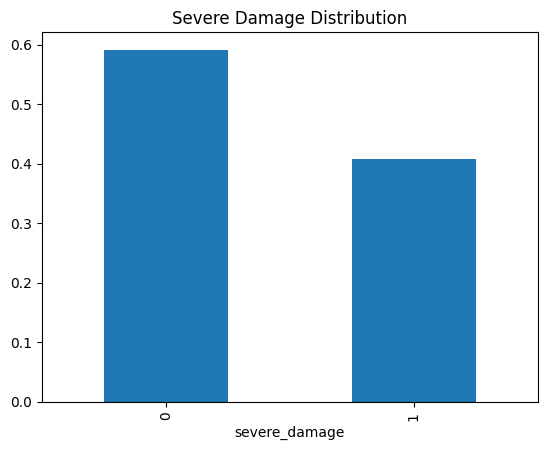

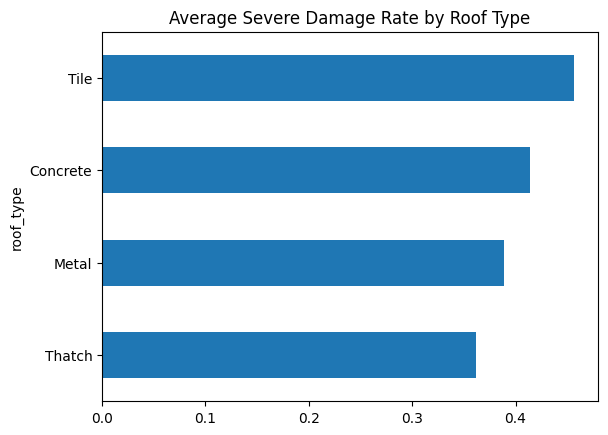

In [13]:
df["severe_damage"].value_counts(normalize=True).plot(kind="bar")
plt.title("Severe Damage Distribution")
plt.show()

roof_effect = df.groupby("roof_type")["severe_damage"].mean().sort_values()
roof_effect.plot(kind="barh")
plt.title("Average Severe Damage Rate by Roof Type")
plt.show()


In [14]:
X = df.drop(columns="severe_damage")
y = df["severe_damage"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Baseline Accuracy: {y_train.value_counts(normalize=True).max():.2f}")

model_lr = make_pipeline(OneHotEncoder(use_cat_names=True), LogisticRegression(max_iter=2000))
model_lr.fit(X_train, y_train)
print(f"LR Train Accuracy: {model_lr.score(X_train, y_train):.3f}")
print(f"LR Validation Accuracy: {model_lr.score(X_val, y_val):.3f}")


Baseline Accuracy: 0.60
LR Train Accuracy: 0.594
LR Validation Accuracy: 0.568


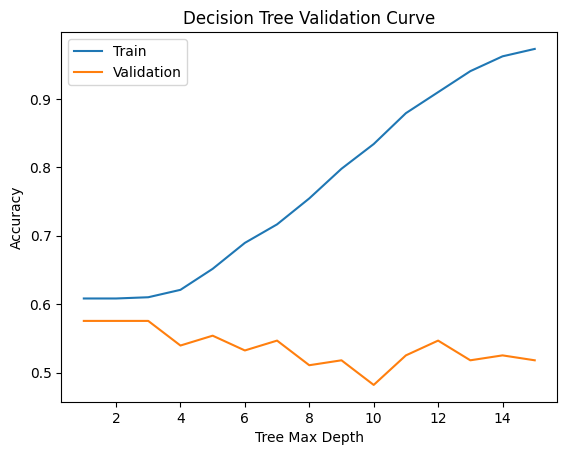

In [15]:
depths = range(1, 16)
train_scores, valid_scores = [], []

for d in depths:
    model_dt = make_pipeline(OrdinalEncoder(), DecisionTreeClassifier(max_depth=d, random_state=42))
    model_dt.fit(X_train, y_train)
    train_scores.append(model_dt.score(X_train, y_train))
    valid_scores.append(model_dt.score(X_val, y_val))

plt.plot(depths, train_scores, label="Train")
plt.plot(depths, valid_scores, label="Validation")
plt.xlabel("Tree Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Decision Tree Validation Curve")
plt.show()


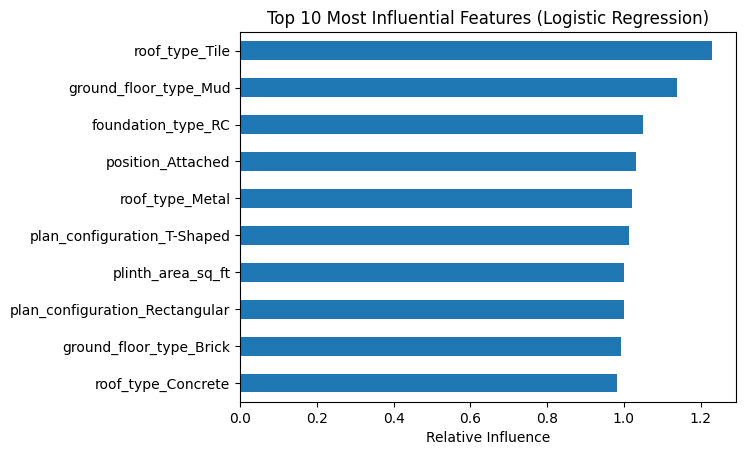

In [16]:
names = model_lr.named_steps["onehotencoder"].get_feature_names_out()
weights = model_lr.named_steps["logisticregression"].coef_[0]
importance = pd.Series(np.exp(weights), index=names).sort_values()

importance.tail(10).plot(kind="barh")
plt.title("Top 10 Most Influential Features (Logistic Regression)")
plt.xlabel("Relative Influence")
plt.show()


✅ **Notebook Complete!**
- Data joined, cleaned, and explored  
- Models trained and evaluated  
- Visual insights created  

